In [2]:
# import libaries
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import euclidean
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns



import os
from dotenv import load_dotenv

In [3]:
#functions to get tracks from spotify

def get_access_token(id: str, secret: str):
    token_url = 'https://accounts.spotify.com/api/token'
    credentials = f'{id}:{secret}'
    encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')

    headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-type': 'application/x-www-form-urlencoded',
    }

    data = {
        'grant_type': 'client_credentials'
    }

    print("getting access token from spotify")
    response = requests.post(token_url, headers=headers, data=data)
    if response.status_code == 200:

        print("fetched token successfully, token:",response.json()['access_token'])

        return response.json()['access_token']

    else:
        raise Exception('Failed to retrieve access token')

def get_playlist_tracks(playlist_id, token):
    all_tracks = []
    limit = 100
    offset = 0
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    print("getting playlists from spotify")
    while True:
        params = {
            'limit': limit,
            'offset': offset,
        }
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            print("fetched playlists from spotify succesfully")
            data = response.json()
            all_tracks.extend([item['track'] for item in data['items']])

            if len(data['items']) < limit:
                break
            else:
                offset += limit
        else:
            raise Exception(f"Failed to retrieve tracks: {response.status_code}")
    return all_tracks




def get_audio_features_for_tracks(playlists_ids, token):
    url = f'https://api.spotify.com/v1/audio-features'
    headers = {
        'Authorization': f'Bearer {token}',
    }

    params = {
        'ids': ','.join(playlists_ids)
    }

    print("getting audio features from spotify")
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched audio features from spotify")
        return response.json()['audio_features']
    else:
        raise Exception(f"Failed to retrieve audio features: {response.status_code}")


def get_playlist_audio_features(playlists, token):

    audio_features = []
    for i in range(0, len(playlists), 100):
        batch_track_ids = [playlist["id"] for playlist in playlists[i:i+100]]
        features = get_audio_features_for_tracks(batch_track_ids, token)
        audio_features.extend(features)

    return audio_features



In [4]:
# the function to get recommendations based on some tracks, target audio features (if any)
# this will be used to benchmark results

def get_recommendations(seed_tracks, target_audio_features, token):
    url = 'https://api.spotify.com/v1/recommendations'
    headers = {
        "Authorization": f'Bearer {token}'
    }

    params = {
        'seed_tracks': ','.join(seed_tracks),
        'limit': 1,
    }

    if target_audio_features['danceability'] != None:
        params['target_danceability'] = target_audio_features['danceability']
    if target_audio_features['energy'] != None:
        params['target_energy'] = target_audio_features['energy']
    if target_audio_features['valence'] != None:
        params['target_valence'] = target_audio_features['valence']
    if target_audio_features['tempo'] != None:
        params['target_tempo'] = target_audio_features['tempo']
    if target_audio_features['loudness'] != None:
        params['target_loudness'] = target_audio_features['loudness']
    if target_audio_features['speechiness'] != None:
        params['target_speechiness'] = target_audio_features['speechiness']
    if target_audio_features['acousticness'] != None:
        params['target_acousticness'] = target_audio_features['acousticness']
    if target_audio_features['instrumentalness'] != None:
        params['target_instrumentalness'] = target_audio_features['instrumentalness']
    if target_audio_features['liveness'] != None:
        params['target_liveness'] = target_audio_features['liveness']
    if target_audio_features['mode'] != None:
        params['target_mode'] = round(target_audio_features['mode'])
    if target_audio_features['key'] != None:
        params['target_key'] = round(target_audio_features['key'])
    if target_audio_features['seed_genre'] != None:
        params['seed_genre'] = target_audio_features['seed_genre']

    print("getting recommendations from spotify API")
    print(f'with {seed_tracks}')
    print(f'and {target_audio_features}')
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        print("fetched recommendations successfully")
        return response.json()['tracks']
    else:
        raise Exception(f"failed to get recommendations: {response.status_code}, {response.json()}")

In [5]:
# functions to manipulate dataset

def preprocess_features(audio_features_df):
    #scale the the selected audio features so they have a mean of 0 and sd of 1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(audio_features_df)
    
    return pd.DataFrame(X_scaled, columns=audio_features_df.columns)

def extract_artists_name(artists):
    return ', '.join([artist['name'] for artist in artists])
    # return artists[0]['name'] ### works if there is only 1 artist

In [6]:
# get id and secret from .env file, then request token from spotify api
load_dotenv()
id = os.getenv('API_ID')
secret = os.getenv('API_SECRET')
print(id)
print(secret)


token = get_access_token(id, secret)

a92443ccaafd4f6790058418cc77ab4e
197bfdc600b14f4497c93263eb973948
getting access token from spotify
fetched token successfully, token: BQDRyJH--bG-5IcWymH_DCbnNMggKpKw-Hje7wgTOXYoX-kv0jnPv5CYDu3EFpqhZzpxM5jjjOQdZdv97jq8bbZLrui8gRygEjQjXGd3hmHpUYqeKF0


In [7]:
#import dataset and show some rows of dataset
dataset = pd.read_csv("dataset.csv")

dataset.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [40]:
#columns of dataset
print(dataset.size, dataset.shape)
dataset.columns
dataset.describe()

2530000 (110000, 23)


,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_encoded
count,110000.000000,110000.000000,1.100000e+05,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,56417.681818,33.125255,2.279680e+05,0.565955,0.639906,5.305700,-8.320723,0.637773,0.084640,0.318388,0.160053,0.214816,0.474382,122.080778,3.902918,15704.990100
std,32929.196029,22.072403,1.084383e+05,0.173820,0.252443,3.559395,5.069331,0.480646,0.106518,0.333759,0.313047,0.191897,0.259977,29.913437,0.436499,9039.506833
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27499.750000,17.000000,1.734650e+05,0.455000,0.469000,2.000000,-10.079250,0.000000,0.035900,0.017200,0.000000,0.098000,0.259000,99.533750,4.000000,7987.000000
50%,55999.500000,34.000000,2.125710e+05,0.580000,0.683000,5.000000,-7.058000,1.000000,0.048700,0.174000,0.000044,0.132000,0.464000,122.015000,4.000000,15635.000000
75%,84499.250000,50.000000,2.618870e+05,0.694000,0.853000,8.000000,-5.042000,1.000000,0.084100,0.604000,0.056500,0.276000,0.684000,140.041000,4.000000,23543.250000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000,31267.000000


In [9]:
#list of unique track genre in the dataset
print(dataset['track_genre'].unique().size)
dataset['track_genre'].unique()

114


array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [10]:
#map similar genres to the same genre, so that the model gives better accuracy
#electronic has a lot, and it seems that many songs are predicted as electronic

genre_mapping = {
    'pop': ['pop', 'indie-pop', 'pop-film', 'power-pop', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'k-pop', 'anime', 'cantopop', 'mandopop', 'synth-pop'],
    'rock': ['goth', 'emo', 'rock', 'alt-rock', 'hard-rock', 'punk-rock', 'punk', 'rock-n-roll', 'grunge', 'psych-rock', 'alternative', 'rockabilly'],
    'hip-hop': ['hip-hop', 'rap', 'trap', 'trip-hop', 'disco', 'funk'],
    'electronic': ['party', 'dance', 'edm', 'electronic', 'techno', 'trance', 'house', 'deep-house', 'club', 'electro', 'progressive-house', 'idm', 'drum-and-bass', 'breakbeat', 'garage', 'minimal-techno', 'detroit-techno', 'chicago-house'],
    'jazz_blues': ['jazz', 'blues', 'soul', 'gospel'],
    'classical': ['classical', 'opera', 'piano'],
    'metal': ['heavy-metal', 'black-metal', 'death-metal', 'metalcore', 'grindcore', 'hardcore', 'hardstyle'],
    'country': ['country', 'honky-tonk'],
    'folk': ['folk', 'bluegrass', 'singer-songwriter', 'guitar', 'tango'],
    'latin': ['latin', 'latino', 'salsa', 'samba', 'forro', 'pagode', 'mpb', 'sertanejo'],
    'world_music': ['world-music', 'afrobeat', 'turkish', 'indian', 'swedish', 'iranian', 'malay', 'french', 'german', 'brazil', 'british', 'spanish'],
    'reggae_dub': ['reggae', 'reggaeton' 'dub', 'dubstep', 'dancehall', 'ska'],
    'rnb_soul': ['r-n-b', 'soul', 'groove'],
    'ambient_new_age': ['ambient', 'new-age', 'chill', 'study', 'sleep', 'acoustic'],
    'soundtracks_theme': ['disney', 'show-tunes', 'comedy', 'children', 'kids', 'happy', 'indie', 'industrial'],
    'romance': ['romance', 'sad'],
}

genre_reverse_mapping = {subgenre: main_genre for main_genre, subgenres in genre_mapping.items() for subgenre in subgenres}

# map each genre in the dataset to the new genre, if new genre does not exist (genre not in the list above), it will be None
dataset['main_genre'] = dataset['track_genre'].map(genre_reverse_mapping)

# drop all None values 
dataset = dataset.dropna(subset=['main_genre'])

print(dataset.size, dataset.shape)
print(dataset.columns)
print(dataset[['track_genre', 'main_genre']].head())

2420000 (110000, 22)
Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'main_genre'],
      dtype='object')
  track_genre       main_genre
0    acoustic  ambient_new_age
1    acoustic  ambient_new_age
2    acoustic  ambient_new_age
3    acoustic  ambient_new_age
4    acoustic  ambient_new_age


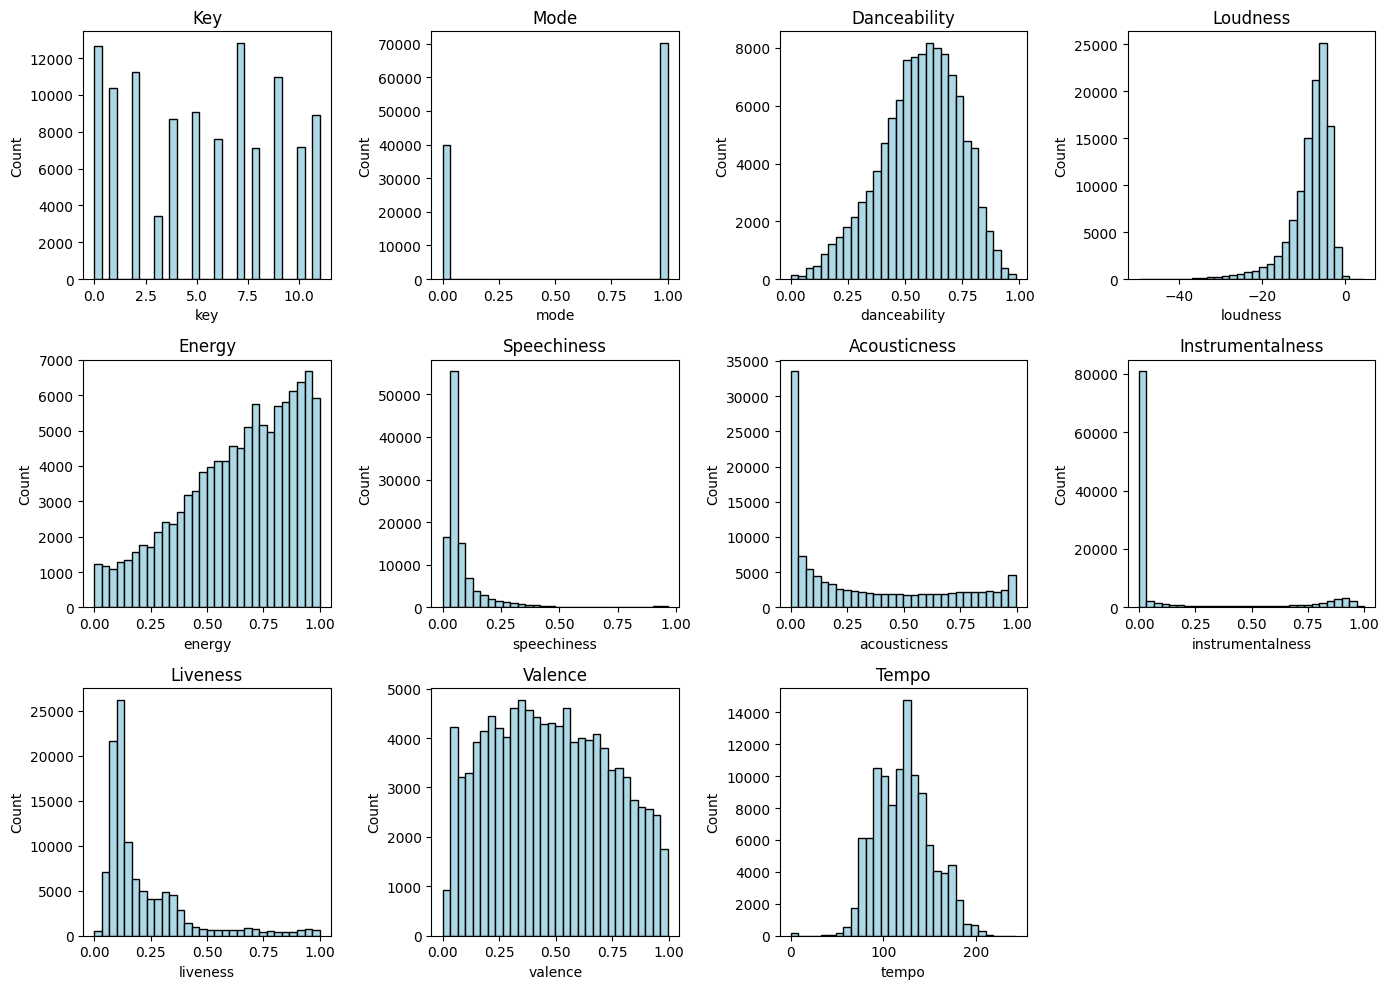

In [11]:
#plot the histogram of features
audio_features = ['key', 'mode', 'danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(14,10))
for i, feature in enumerate(audio_features):
    plt.subplot(3, 4, i + 1)
    plt.hist(dataset[feature], bins= 30, color='lightblue', edgecolor='black')
    plt.title(f'{feature.capitalize()}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
#extract the key features from the dataset, then split into train and test datasets (using 'track_genre' as the label)

#encode the artist name
label_encoder = LabelEncoder()
dataset['artists_encoded'] = label_encoder.fit_transform(dataset['artists'])
features_df = dataset[['key', 'mode', 'danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'artists_encoded']]
features_df = preprocess_features(features_df)
print(dataset['artists_encoded'].unique().size)


X_train, X_test, y_train, y_test = train_test_split(features_df, dataset['main_genre'], test_size=0.2, random_state=42)
X_train

31268


,key,mode,danceability,loudness,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artists_encoded
72236,-0.928730,0.753629,0.955272,-0.472900,-0.023394,-0.460390,-0.621374,-0.511278,-0.207486,1.583293,-1.206981,-0.908681
32086,-0.366834,0.753629,-0.592310,1.037168,0.859977,-0.201277,-0.802344,-0.511278,-0.160586,1.467897,-0.348801,0.382878
45550,0.756958,0.753629,-0.500260,1.336617,1.267992,-0.363692,-0.917098,-0.510961,-0.108474,-0.363043,1.767549,0.870075
104659,-0.928730,-1.326913,-0.459989,0.023617,-0.859230,-0.503575,1.802541,0.098857,-0.755179,0.525502,0.848292,1.071525
5660,0.476010,0.753629,-0.592310,0.976015,1.311566,0.482179,-0.949756,-0.511278,0.475175,-0.101480,-1.037859,-0.619615
...,...,...,...,...,...,...,...,...,...,...,...,...
54886,1.599802,-1.326913,0.132580,-0.587512,-0.827540,-0.544883,1.451988,-0.388931,-0.561845,-0.966946,-0.206021,0.673382
76820,-1.209678,-1.326913,1.381001,0.158941,0.352930,-0.439736,-0.908409,-0.511278,-0.697335,1.925633,-0.003235,-1.104710
103694,-1.209678,0.753629,0.811445,-0.137154,-0.261073,-0.565537,0.819792,-0.511161,-0.792178,0.856302,-0.870709,0.793964
860,0.195062,0.753629,-0.833940,-1.355269,-2.111003,-0.480105,1.886435,-0.511278,-0.660336,-1.370830,-0.597152,1.276957


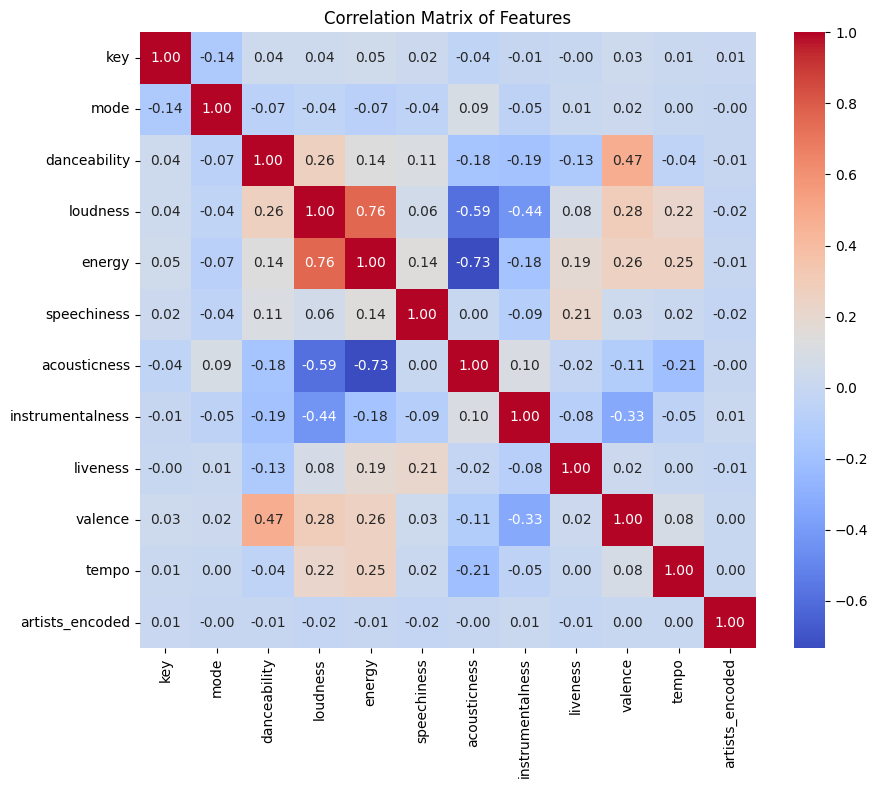

In [13]:
# Correlation matrix
correlation_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


In [14]:
# check the model for the best k to be used in KNN model and plot the graph to visualize
# after finishing, we will use the k with the best accuracy for our model

#range of k values to test
k_values = range(1, 21)  #testing from 1 to 20
accuracies = []
best_k = 1
best_accuracy = 0

for k in k_values:  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    print("k= ", k)
    print("accuracy= ", accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

k=  1
accuracy=  0.38545454545454544
k=  2
accuracy=  0.3738181818181818
k=  3
accuracy=  0.36822727272727274
k=  4
accuracy=  0.37363636363636366


KeyboardInterrupt: 

In [15]:
#training the model using KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [16]:
#training the model using random forest
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=150, random_state=42)

In [17]:
#training the model using MLP
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', batch_size=32, max_iter=100, random_state=42)
mlp.fit(X_train, y_train)

C:\Users\User_Win10x64\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=32, hidden_layer_sizes=(32, 16), max_iter=100,
              random_state=42)

Accuracy: 38.55%
Confusion Matrix:
 [[ 418  103   11   87   88   14   19   21   11   91   18   22   40   58
    59  112]
 [ 101  219   12   12   31    3    8   10    4   32    5   10   44   12
    43   67]
 [   7    9  206   13   34    3   16    7    2   27    5    7   30    4
    15   25]
 [  73   23   13 2058   27  159   23   63  134  233   81   98  161   11
   178  257]
 [  76   30   48   31  302   10   28   57    6   95   12   23   88   25
    63  121]
 [  25    2    6  145   21  176    8   49    7  100   44   50   69    4
    32   77]
 [  17   28   12   24   23   16  171   27    6   73   11   26   64    6
    23   97]
 [  11    8   23   57   55   49   27  754   10  100  146   62   93    3
    44  112]
 [  10    6    4  149    2   15    9    9  682   83   29   35  183    2
    82  101]
 [  61   28   32  230   96  111   66  112   87  941  104   45  243   23
   165  240]
 [   8    2    2   93    9   41    5  147   35   99  134   10   84    7
    27   92]
 [  14    3    7   86    9   

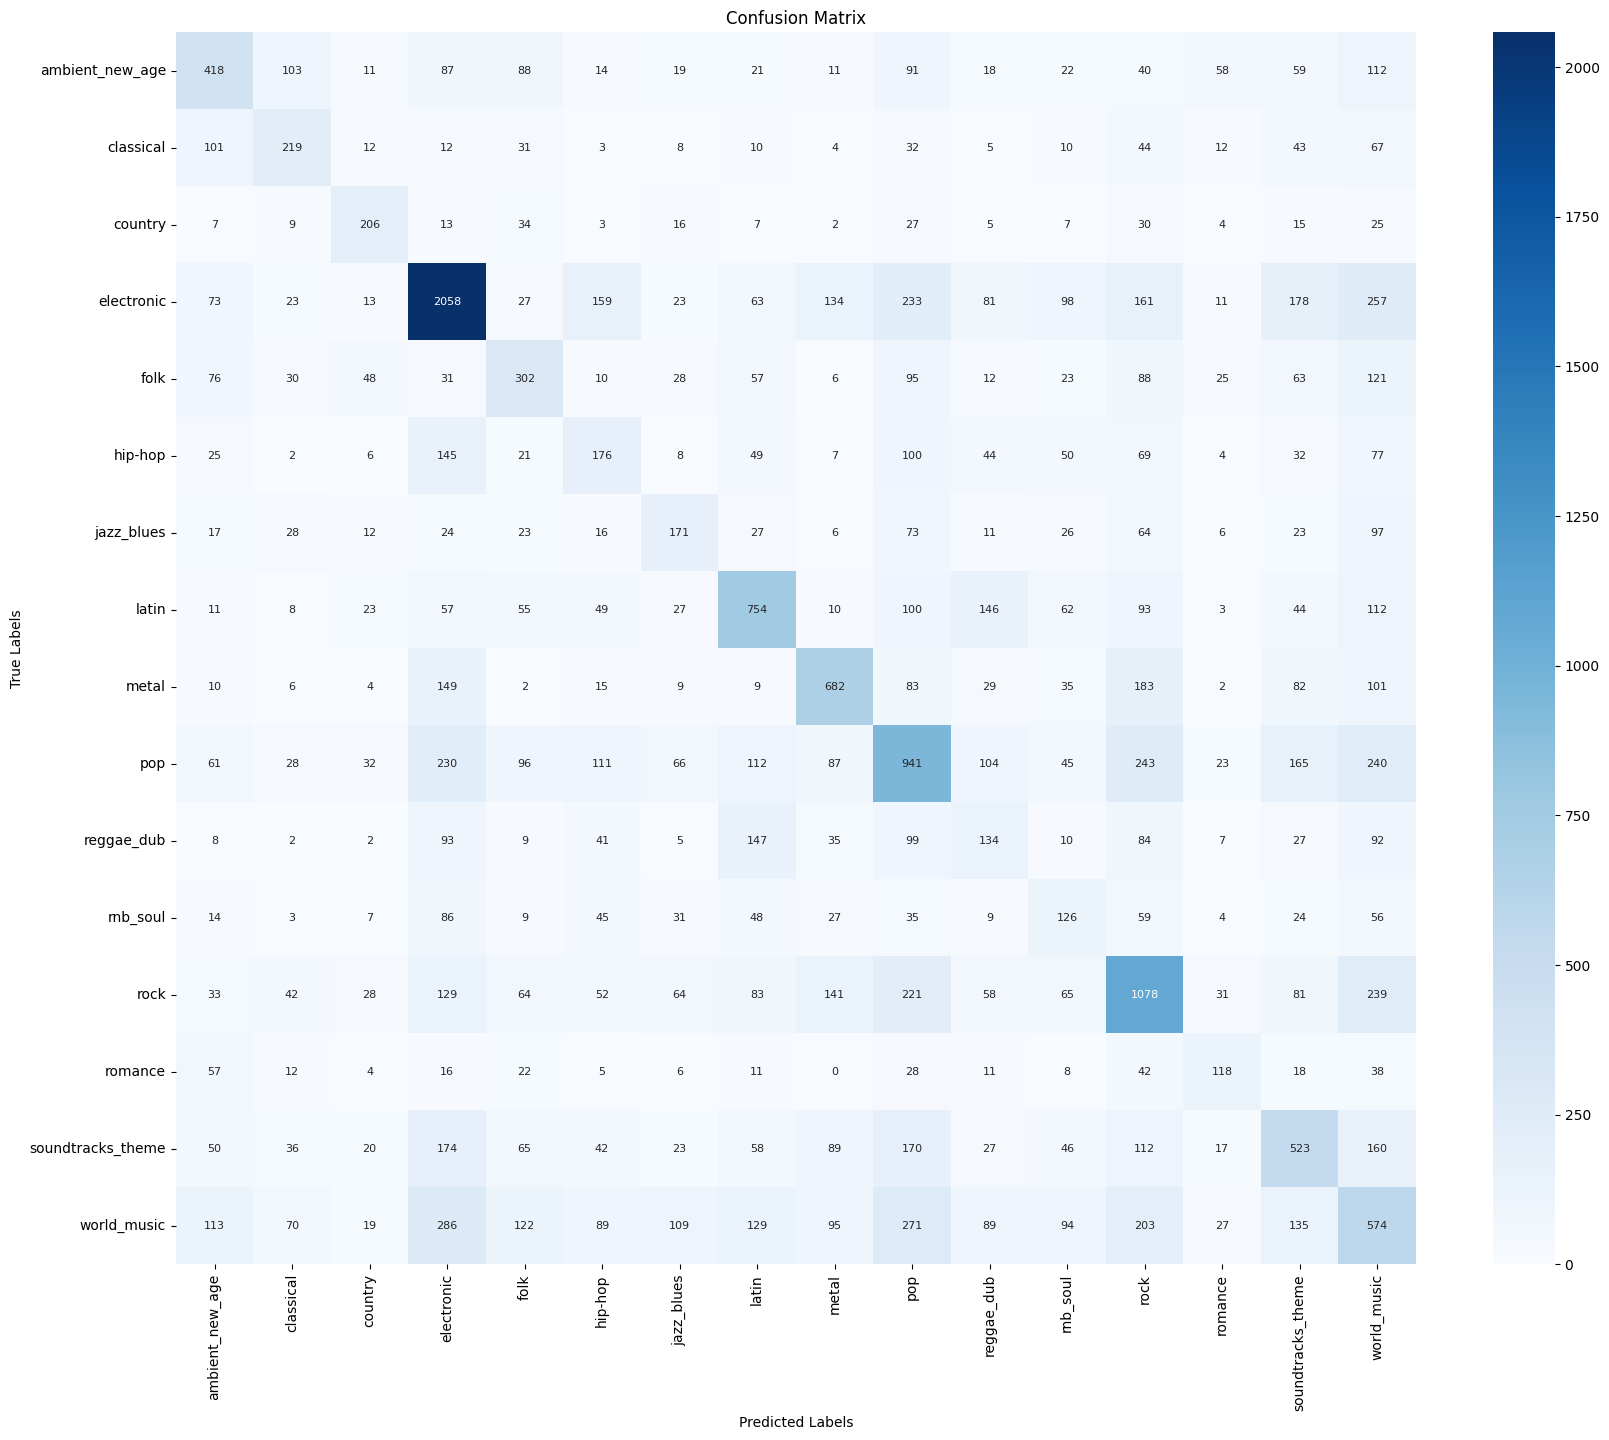

In [ ]:
#test the model and check the accuracy for KNN
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# Number of classes
num_classes = conf_matrix.shape[0]

# Calculate precision, recall, and F1-score for each class
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(num_classes):
    # True Positives (TP) for class i
    tp = conf_matrix[i, i]
    
    # False Positives (FP): sum of column i, excluding the diagonal element
    fp = conf_matrix[:, i].sum() - tp
    
    # False Negatives (FN): sum of row i, excluding the diagonal element
    fn = conf_matrix[i, :].sum() - tp
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    precision_scores.append(precision)
    
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_scores.append(recall)
    
    # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

# Display precision, recall, and F1-score for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision_scores[i]:.2f}")
    print(f"  Recall: {recall_scores[i]:.2f}")
    print(f"  F1-score: {f1_scores[i]:.2f}")
    print()

# Plot the confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 48.49%
Confusion Matrix:
 [[ 596   67    5   85   79    3    5   13    4   94    5   15   37   49
    28   87]
 [  98  280    0   14   35    0    2   13    4   34    2    0   38    7
    19   67]
 [   0    1  231   10   37    0    4   15    0   43    3    0   36    0
     5   25]
 [  72    3    4 2650   24   59    6   44   83  179   31   41  153    4
    60  179]
 [  88   11   13   26  404    0    7   62    2  136    2    2   94   10
    43  115]
 [  19    0    1  217   12  130    0   76    0  111   21   35   64    1
    23  105]
 [  12   13    3   27   22    4  169   30    2  103    2   16   78    1
    16  126]
 [   3    3    1   43   27   17   10 1070    2  110   64   28   55    2
    26   93]
 [   4    1    0  134    0    2    0    5  904   58   10   17  193    0
    41   32]
 [  44    8    9  305   54   46   36  101   69 1245   47    1  273   11
    95  240]
 [   2    0    0  124    1    9    0  184   37  123   95    0   91    0
    11  118]
 [  10    3    1   98   10   

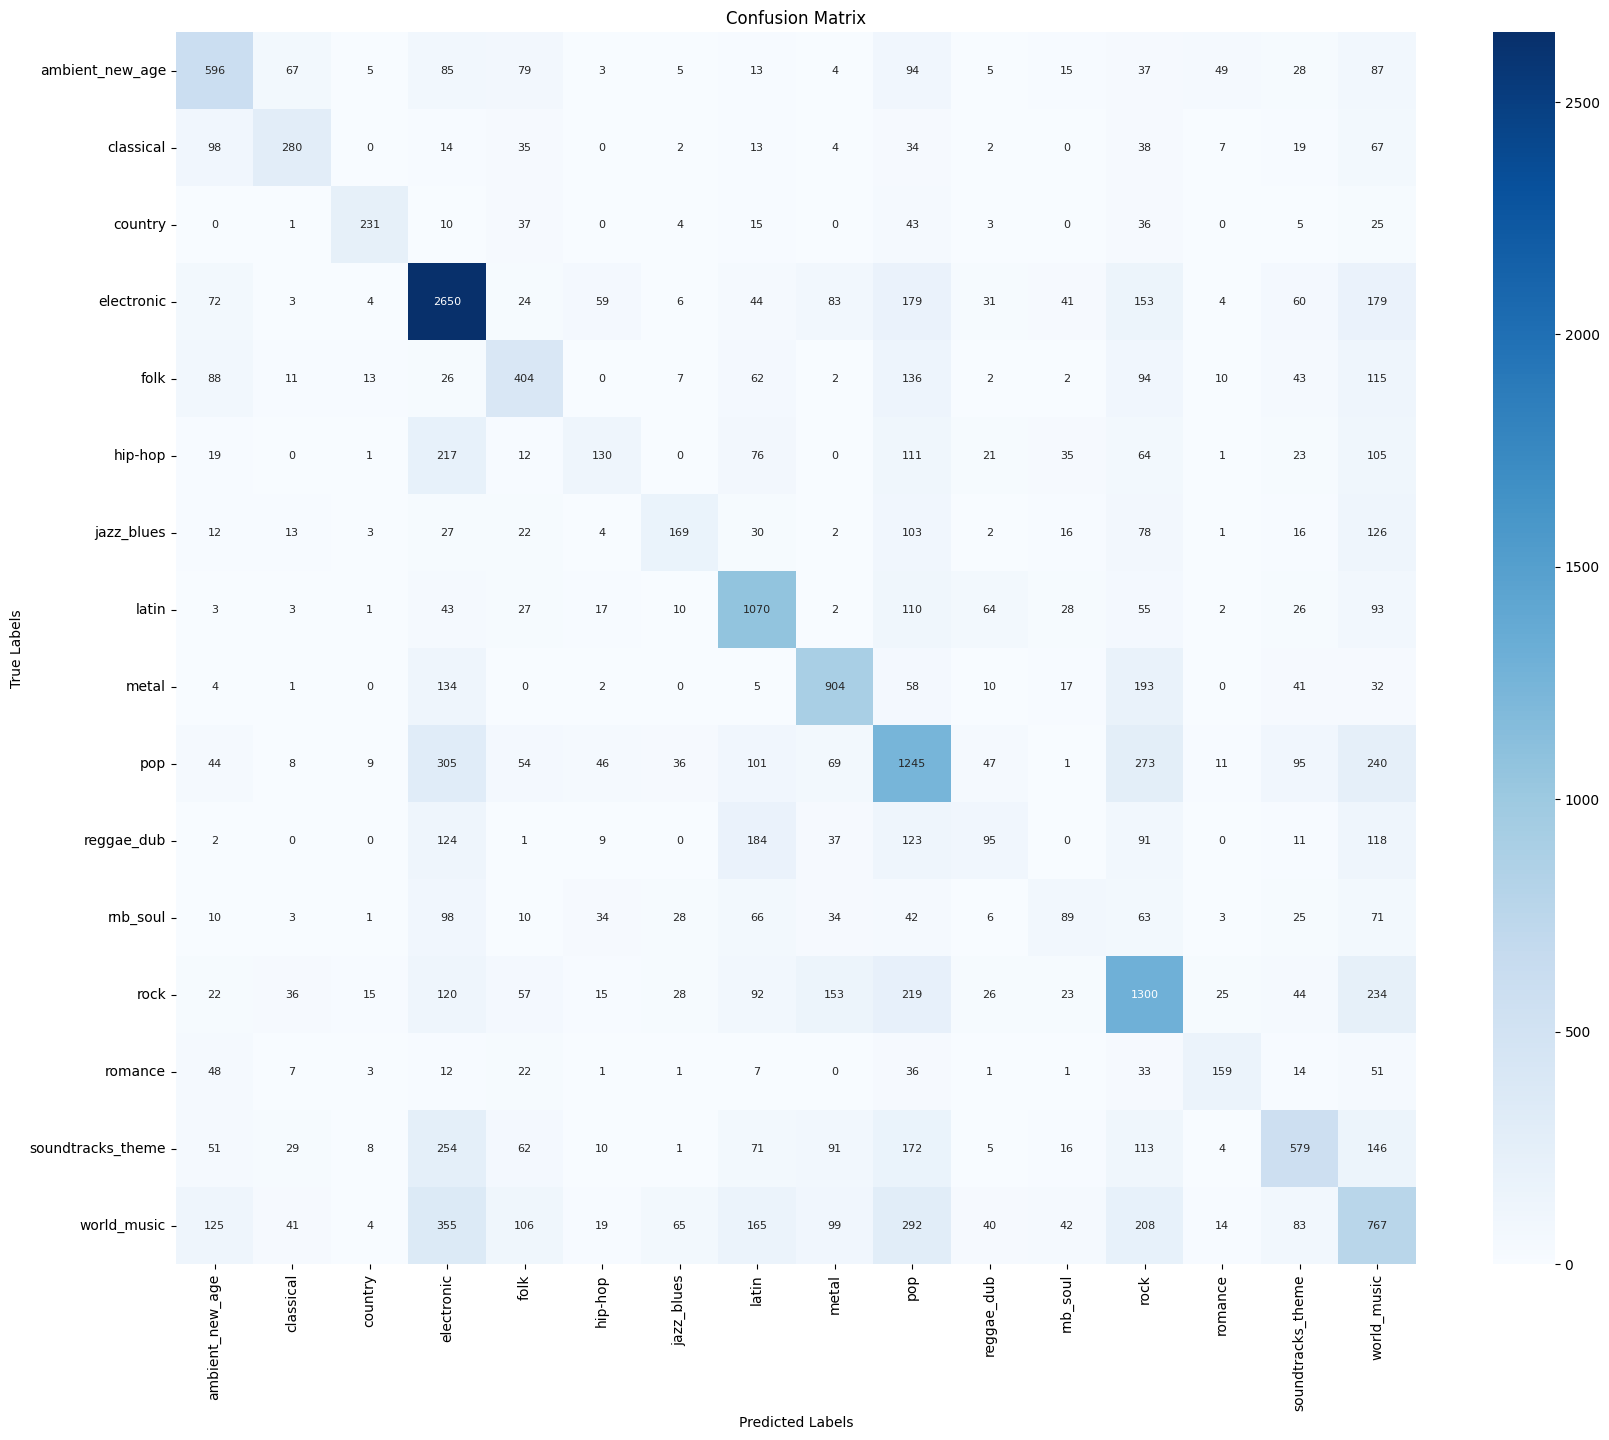

In [34]:
#test the model accuracy for random forest
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# Number of classes
num_classes = conf_matrix.shape[0]

# Calculate precision, recall, and F1-score for each class
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(num_classes):
    # True Positives (TP) for class i
    tp = conf_matrix[i, i]
    
    # False Positives (FP): sum of column i, excluding the diagonal element
    fp = conf_matrix[:, i].sum() - tp
    
    # False Negatives (FN): sum of row i, excluding the diagonal element
    fn = conf_matrix[i, :].sum() - tp
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    precision_scores.append(precision)
    
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_scores.append(recall)
    
    # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

# Display precision, recall, and F1-score for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision_scores[i]:.2f}")
    print(f"  Recall: {recall_scores[i]:.2f}")
    print(f"  F1-score: {f1_scores[i]:.2f}")
    print()

# Plot the confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 39.15%
Confusion Matrix:
 [[ 596   67    5   85   79    3    5   13    4   94    5   15   37   49
    28   87]
 [  98  280    0   14   35    0    2   13    4   34    2    0   38    7
    19   67]
 [   0    1  231   10   37    0    4   15    0   43    3    0   36    0
     5   25]
 [  72    3    4 2650   24   59    6   44   83  179   31   41  153    4
    60  179]
 [  88   11   13   26  404    0    7   62    2  136    2    2   94   10
    43  115]
 [  19    0    1  217   12  130    0   76    0  111   21   35   64    1
    23  105]
 [  12   13    3   27   22    4  169   30    2  103    2   16   78    1
    16  126]
 [   3    3    1   43   27   17   10 1070    2  110   64   28   55    2
    26   93]
 [   4    1    0  134    0    2    0    5  904   58   10   17  193    0
    41   32]
 [  44    8    9  305   54   46   36  101   69 1245   47    1  273   11
    95  240]
 [   2    0    0  124    1    9    0  184   37  123   95    0   91    0
    11  118]
 [  10    3    1   98   10   

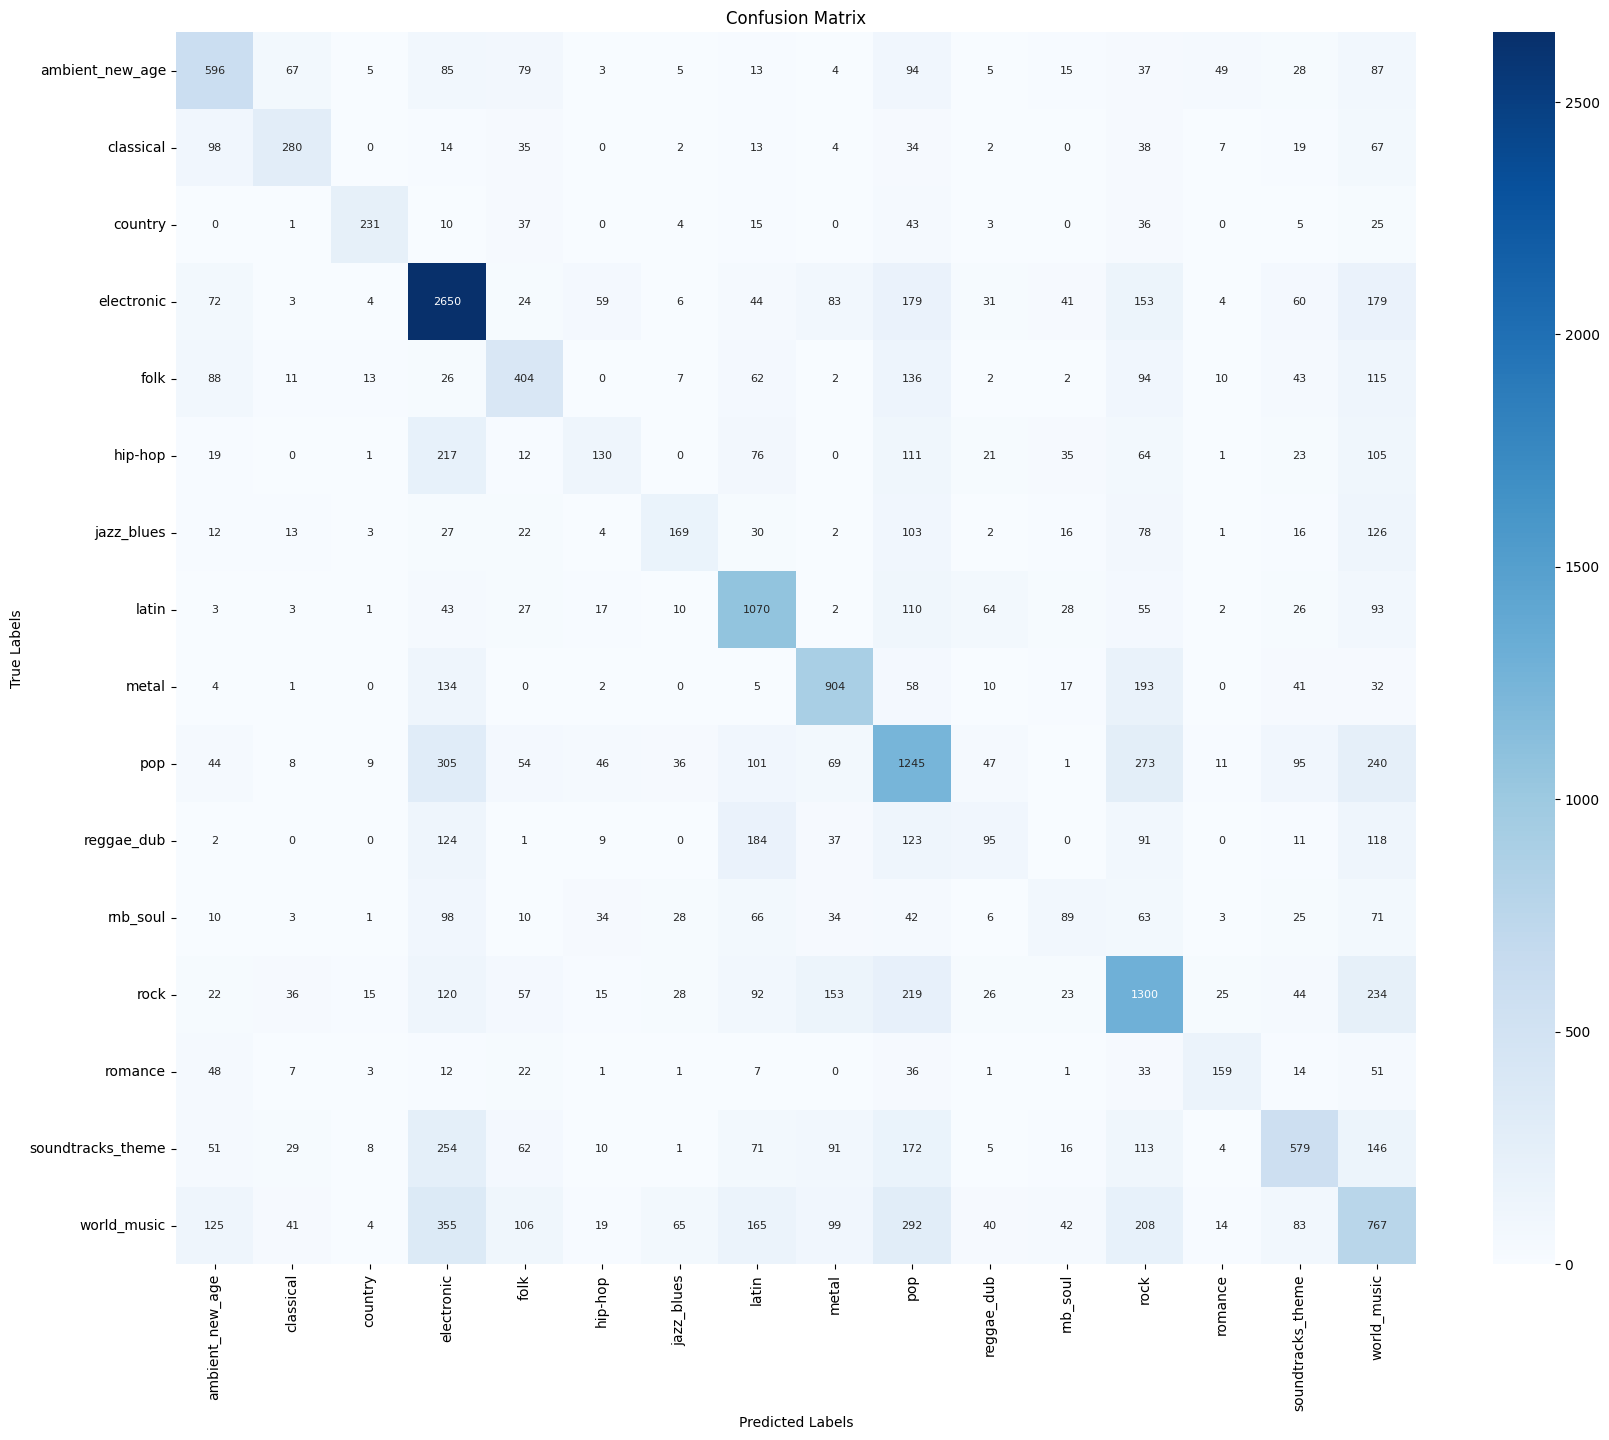

In [41]:
#test the model and check the accuracy for MLP
y_pred_mlp = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {accuracy * 100:.2f}%")

#generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# Number of classes
num_classes = conf_matrix.shape[0]

# Calculate precision, recall, and F1-score for each class
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(num_classes):
    # True Positives (TP) for class i
    tp = conf_matrix[i, i]
    
    # False Positives (FP): sum of column i, excluding the diagonal element
    fp = conf_matrix[:, i].sum() - tp
    
    # False Negatives (FN): sum of row i, excluding the diagonal element
    fn = conf_matrix[i, :].sum() - tp
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    precision_scores.append(precision)
    
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recall_scores.append(recall)
    
    # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

# Display precision, recall, and F1-score for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision_scores[i]:.2f}")
    print(f"  Recall: {recall_scores[i]:.2f}")
    print(f"  F1-score: {f1_scores[i]:.2f}")
    print()

# Plot the confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={"size": 8})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# finding recommendation based of given playlist, that is in the given genre

def recommend_song_from_playlist_and_genre(playlist, genre):
    # predicting the recommendation song based of the audio features
    audio_features = ['key', 'mode', 'danceability', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

    #calculate the average of the specified columns
    average_features = playlist[audio_features].mean()
    #print("\nAverage Audio Features:\n", average_features)


    # find the closest match in the dataset using euclidean distance
    min_distance = float('inf')
    recommended_song = None
    for i, row in dataset[dataset['track_genre'].isin(genre_mapping[genre])].iterrows():
        song_features = row[audio_features]
        distance = euclidean(song_features, average_features)
        
        if distance < min_distance:
            min_distance = distance
            recommended_song = row

    print("Recommended Song:")
    return recommended_song[['track_name', 'artists'] + audio_features + ['track_genre']]

In [22]:
# randomizing 10 songs, and using that 10 songs to predict the genre of each song, then use the maximum occurence of genres to generate a recommendation song
random_songs = dataset.sample(n=5, random_state=41)
random_songs_feature = random_songs[audio_features + ['artists_encoded']]
random_songs_feature = preprocess_features(random_songs_feature)

# predict from model
genre = rf.predict(random_songs_feature)

# get the max occurence of genres
genre_max = genre.max()

# generate recommedation song
recommended_model = recommend_song_from_playlist_and_genre(random_songs, genre_max)
recommended_model

Recommended Song:


track_name                            Sweet Escape
artists             Lonely Night;Ari;Lost Dreamers
key                                              7
mode                                             1
danceability                                 0.603
loudness                                    -8.497
energy                                       0.518
speechiness                                 0.0468
acousticness                                0.0092
instrumentalness                          0.000012
liveness                                      0.12
valence                                      0.249
tempo                                      124.009
track_genre                                 french
Name: 36809, dtype: object

In [23]:
#compare result to the recommendation from spotify api

#fetch song info from spotify API
random_songs_features_mean = random_songs[audio_features].mean()
random_songs_features_mean['seed_genre'] = genre_max
recommended_spotify = get_recommendations(seed_tracks=random_songs[0:5]['track_id'], target_audio_features=random_songs_features_mean, token=token)
recommended_spotify_df = pd.DataFrame(recommended_spotify)
recommended_spotify_df['artist_names'] = recommended_spotify_df['artists'].apply(extract_artists_name)

#fetch song audio features from spotify API
recommended_spotify_audio_features = get_audio_features_for_tracks([recommended_spotify_df.iloc[0]['id']], token)
recommended_spotify_audio_features = pd.DataFrame(recommended_spotify_audio_features)

print(recommended_spotify_df.iloc[0][['name', 'artist_names']])

getting recommendations from spotify API
with 94657    1hQaFnjMPNskSo05giqiVR
29112    55tevo6vHJEn12nzuSdJ6R
21863    0Eq1YipYrFdRzPKT8y7iOC
29254    0adZjn5WV3b0BcZbvSi0y9
133      1Qo3taHLFSQpzLm5Sty7M4
Name: track_id, dtype: object
and key                         7.8
mode                        0.8
danceability             0.6266
loudness                -8.7548
energy                  0.65658
speechiness             0.11204
acousticness            0.38078
instrumentalness       0.177544
liveness                0.18532
valence                  0.4544
tempo                  124.6132
seed_genre          world_music
dtype: object
fetched recommendations successfully
getting audio features from spotify
fetched audio features from spotify
name                      Alive
artist_names    Zeds Dead, MKLA
Name: 0, dtype: object


In [24]:
# the recommended song and its audio features from spotify recommendation, this will be used to benchmark our result
print(recommended_spotify_df.iloc[0][['name', 'artist_names']])
print(recommended_spotify_audio_features.iloc[0])

name                      Alive
artist_names    Zeds Dead, MKLA
Name: 0, dtype: object
danceability                                                    0.618
energy                                                          0.758
key                                                                 8
loudness                                                       -7.996
mode                                                                1
speechiness                                                    0.0336
acousticness                                                   0.0087
instrumentalness                                                0.102
liveness                                                        0.147
valence                                                         0.144
tempo                                                         120.987
type                                                   audio_features
id                                             5bFuHlXKw66Uu2cHKn5bf8
uri

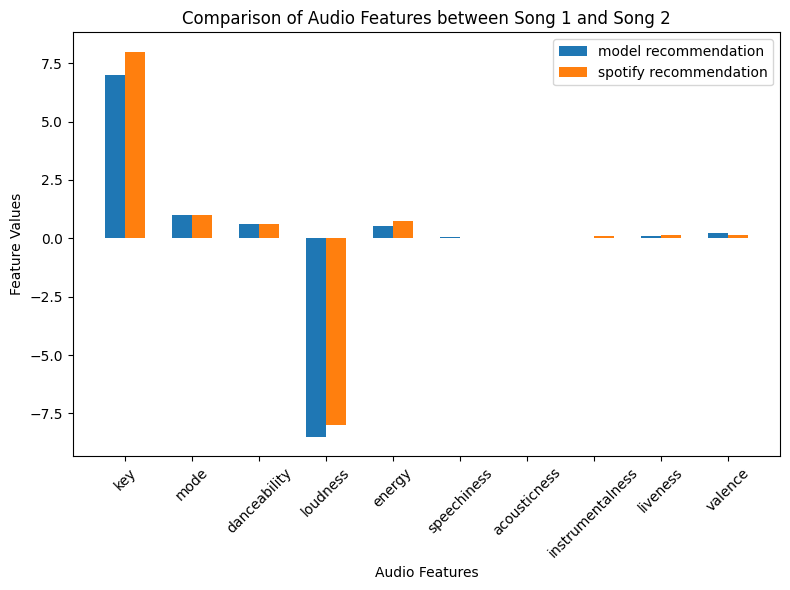

In [25]:
audio_features.remove('tempo')

song_1_values = recommended_model[audio_features].values
song_2_values = recommended_spotify_audio_features.iloc[0][audio_features].values

# Create the bar plot
x = range(len(audio_features))  # X axis positions for each feature

# Set width for bars
width = 0.3

plt.figure(figsize=(8, 6))

# Plot the bars for both songs
plt.bar(x, song_1_values, width=width, label='model recommendation', align='center')
plt.bar([p + width for p in x], song_2_values, width=width, label='spotify recommendation', align='center')

# Add labels and title
plt.xlabel('Audio Features')
plt.ylabel('Feature Values')
plt.title('Comparison of Audio Features between Song 1 and Song 2')

# Set the x-ticks to the feature names
plt.xticks([p + width/2 for p in x], audio_features, rotation=45)
  

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()